In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=f2c91e4992fe4d01ec27282219a4a771de317a59b4c19cc8e94d6fe2500be5fb
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
%matplotlib inline

In [ ]:
spark = SparkSession.builder.appName("Transport for London").getOrCreate()

In [ ]:
spark

In [ ]:
!wget https://cycling.data.tfl.gov.uk/usage-stats/cyclehireusagestats-2014.zip
!unzip cyclehireusagestats-2014.zip

--2024-05-20 10:25:10--  https://cycling.data.tfl.gov.uk/usage-stats/cyclehireusagestats-2014.zip
Resolving cycling.data.tfl.gov.uk (cycling.data.tfl.gov.uk)... 104.16.98.104, 104.16.97.104
Connecting to cycling.data.tfl.gov.uk (cycling.data.tfl.gov.uk)|104.16.98.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 225215129 (215M) [application/zip]
Saving to: ‘cyclehireusagestats-2014.zip’

cyclehireusagestats 100%[===================>] 214.78M   151MB/s    in 1.4s    

2024-05-20 10:25:12 (151 MB/s) - ‘cyclehireusagestats-2014.zip’ saved [225215129/225215129]

Archive:  cyclehireusagestats-2014.zip
  inflating: 1. Journey Data Extract 05Jan14-02Feb14.csv  
  inflating: 10a. Journey Data Extract 14Sep14-27Sep14.csv  
  inflating: 10b. Journey Data Extract 28Sep14-11Oct14.csv  
  inflating: 11a. Journey Data Extract 12Oct14-08Nov14.csv  
  inflating: 11b. Journey Data Extract 12Oct14-08Nov14.csv  
  inflating: 12a. Journey Data Extract 09Nov14-06Dec14.csv  
  i

In [ ]:
files = "*.csv"

In [ ]:
tfl = spark.read.csv(files, header=True, inferSchema=True)

In [ ]:
tfl.show(5)

+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+
|Rental Id|Duration|Bike Id|        End Date|EndStation Id|     EndStation Name|      Start Date|StartStation Id|   StartStation Name|
+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+
| 34263367|    1080|   9076|24/06/2014 00:57|          695|Islington Green, ...|24/06/2014 00:39|            311|Foley Street, Fit...|
| 34603487|     660|   6328|03/07/2014 11:51|          695|Islington Green, ...|03/07/2014 11:40|             22|Northington Stree...|
| 34689078|     120|   2006|05/07/2014 15:09|          357|Howland Street, F...|05/07/2014 15:07|            311|Foley Street, Fit...|
| 34724273|    1260|   7904|06/07/2014 16:35|          695|Islington Green, ...|06/07/2014 16:14|            311|Foley Street, Fit...|
| 34956750|    1500|   8251|13/07/2014 00:41|          

In [ ]:
tfl.count()

11481596

In [ ]:
tfl.columns

['Rental Id',
 'Duration',
 'Bike Id',
 'End Date',
 'EndStation Id',
 'EndStation Name',
 'Start Date',
 'StartStation Id',
 'StartStation Name']

In [ ]:
tfl.dtypes

[('Rental Id', 'string'),
 ('Duration', 'string'),
 ('Bike Id', 'string'),
 ('End Date', 'string'),
 ('EndStation Id', 'string'),
 ('EndStation Name', 'string'),
 ('Start Date', 'string'),
 ('StartStation Id', 'string'),
 ('StartStation Name', 'string')]

In [ ]:
tfl =  tfl.withColumn("Duration", tfl["Duration"].cast(IntegerType()))

In [ ]:
#Count of the number of the columns.
#Since data.columns returns a list, we can count the elements of the list using the len python len method
print(f"The number of columns in the data dataframe is: {len(tfl.columns)}")

The number of columns in the data dataframe is: 9


In [ ]:
# see how many entries (rows) in data
rows = tfl.count()
print(f"There are {rows/1e6} million rows in the Transport for London dataset")

There are 11.481596 million rows in the Transport for London dataset


In [ ]:
tfl_subset_cols = ["Bike Id","Duration","End Date" ,"EndStation Name","Start Date", "StartStation Name"]

In [ ]:
tfl = tfl.select(tfl_subset_cols)

In [ ]:
tfl.show(5)

+-------+--------+----------------+--------------------+----------------+--------------------+
|Bike Id|Duration|        End Date|     EndStation Name|      Start Date|   StartStation Name|
+-------+--------+----------------+--------------------+----------------+--------------------+
|   9076|    1080|24/06/2014 00:57|Islington Green, ...|24/06/2014 00:39|Foley Street, Fit...|
|   6328|     660|03/07/2014 11:51|Islington Green, ...|03/07/2014 11:40|Northington Stree...|
|   2006|     120|05/07/2014 15:09|Howland Street, F...|05/07/2014 15:07|Foley Street, Fit...|
|   7904|    1260|06/07/2014 16:35|Islington Green, ...|06/07/2014 16:14|Foley Street, Fit...|
|   8251|    1500|13/07/2014 00:41|Cloudesley Road, ...|13/07/2014 00:16|Foley Street, Fit...|
+-------+--------+----------------+--------------------+----------------+--------------------+
only showing top 5 rows



In [ ]:
#Removed null values in the data
dropped_na_df = tfl.na.drop()

In [ ]:
count_after_na_drop = dropped_na_df.count()

In [ ]:
dropped_duplicates_df = dropped_na_df.dropDuplicates()

In [ ]:
count_after_duplicates_drop = dropped_duplicates_df.count()

In [ ]:
df = dropped_duplicates_df.filter(dropped_duplicates_df["Duration"] > 0)

In [ ]:
count_after_dropping_values_less_than_or_equal_to_zero = df.count()

In [ ]:
print(f"Number of null values in the data is: {(rows - count_after_na_drop)/1e6} million")
print(f"Number of duplicate rows: {count_after_na_drop-count_after_duplicates_drop}")
print(f"Removed rows with duration less than or equal to zero: {count_after_duplicates_drop - count_after_dropping_values_less_than_or_equal_to_zero}")

Number of null values in the data is: 1.239245 million
Number of duplicate rows: 228
Removed rows with duration less than or equal to zero: 32274


In [ ]:
df.show(5)

+-------+--------+----------------+--------------------+----------------+--------------------+
|Bike Id|Duration|        End Date|     EndStation Name|      Start Date|   StartStation Name|
+-------+--------+----------------+--------------------+----------------+--------------------+
|  10900|    1200|07/07/2014 09:16|Rochester Row, We...|07/07/2014 08:56|Rossmore Road, Ma...|
|   1635|    2460|08/07/2014 10:00|Guilford Street ,...|08/07/2014 09:19|Watney Street, Sh...|
|  10455|     420|08/07/2014 20:15|Granby Street, Sh...|08/07/2014 20:08|Old Montague Stre...|
|   6448|     300|25/06/2014 19:21|Sadlers Sports Ce...|25/06/2014 19:16|Museum of London,...|
|  11198|    1620|16/07/2014 08:17|Moorfields, Moorgate|16/07/2014 07:50|Clarence Walk, St...|
+-------+--------+----------------+--------------------+----------------+--------------------+
only showing top 5 rows



In [ ]:
df[["Duration"]].summary().show()

+-------+------------------+
|summary|          Duration|
+-------+------------------+
|  count|          10209849|
|   mean|1470.5896100911973|
| stddev|12958.309902541701|
|    min|                60|
|    25%|               480|
|    50%|               840|
|    75%|              1320|
|    max|           2596560|
+-------+------------------+



In [ ]:
#Created a column for the month and year for querying the data effectively
df = df.withColumn("Month", substring(col("Start Date"), 4, 2))
df = df.withColumn("Year", substring(col("Start Date"), 7, 4))
df.show(5)

+-------+--------+----------------+--------------------+----------------+--------------------+-----+----+
|Bike Id|Duration|        End Date|     EndStation Name|      Start Date|   StartStation Name|Month|Year|
+-------+--------+----------------+--------------------+----------------+--------------------+-----+----+
|  10900|    1200|07/07/2014 09:16|Rochester Row, We...|07/07/2014 08:56|Rossmore Road, Ma...|   07|2014|
|   1635|    2460|08/07/2014 10:00|Guilford Street ,...|08/07/2014 09:19|Watney Street, Sh...|   07|2014|
|  10455|     420|08/07/2014 20:15|Granby Street, Sh...|08/07/2014 20:08|Old Montague Stre...|   07|2014|
|   6448|     300|25/06/2014 19:21|Sadlers Sports Ce...|25/06/2014 19:16|Museum of London,...|   06|2014|
|  11198|    1620|16/07/2014 08:17|Moorfields, Moorgate|16/07/2014 07:50|Clarence Walk, St...|   07|2014|
+-------+--------+----------------+--------------------+----------------+--------------------+-----+----+
only showing top 5 rows



In [ ]:
print(f"The number of rows before removal of start date other than 2014 is: {df.count()/1e6} million")

The number of rows before removal of start date other than 2014 is: 10.209849 million


In [ ]:
df = df.filter(df["Year"] == 2014)

In [ ]:
print(f"The number of rows after removal of start date other than 2014 is: {df.count()/1e6} million")

The number of rows after removal of start date other than 2014 is: 9.864161 million


In [ ]:
df.dtypes

[('Bike Id', 'string'),
 ('Duration', 'int'),
 ('End Date', 'string'),
 ('EndStation Name', 'string'),
 ('Start Date', 'string'),
 ('StartStation Name', 'string'),
 ('Month', 'string'),
 ('Year', 'string')]

#DATA EXPLORATION

In [ ]:
df.show(5)

+-------+--------+----------------+--------------------+----------------+--------------------+-----+----+
|Bike Id|Duration|        End Date|     EndStation Name|      Start Date|   StartStation Name|Month|Year|
+-------+--------+----------------+--------------------+----------------+--------------------+-----+----+
|  10900|    1200|07/07/2014 09:16|Rochester Row, We...|07/07/2014 08:56|Rossmore Road, Ma...|   07|2014|
|   1635|    2460|08/07/2014 10:00|Guilford Street ,...|08/07/2014 09:19|Watney Street, Sh...|   07|2014|
|  10455|     420|08/07/2014 20:15|Granby Street, Sh...|08/07/2014 20:08|Old Montague Stre...|   07|2014|
|   6448|     300|25/06/2014 19:21|Sadlers Sports Ce...|25/06/2014 19:16|Museum of London,...|   06|2014|
|  11198|    1620|16/07/2014 08:17|Moorfields, Moorgate|16/07/2014 07:50|Clarence Walk, St...|   07|2014|
+-------+--------+----------------+--------------------+----------------+--------------------+-----+----+
only showing top 5 rows



##Most frequent station by StartStation Name and EndStation Name

In [ ]:
startstation = df.groupBy('StartStation Name').count().orderBy(desc('count'))
startstation.show(10)

+--------------------+-----+
|   StartStation Name|count|
+--------------------+-----+
|Hyde Park Corner,...|99621|
|Belgrove Street ,...|85283|
|Waterloo Station ...|78295|
|Black Lion Gate, ...|70507|
|Albert Gate, Hyde...|68496|
|Waterloo Station ...|51780|
|Wormwood Street, ...|51406|
|Hop Exchange, The...|50002|
|Speakers' Corner ...|48210|
|Wellington Arch, ...|47236|
+--------------------+-----+
only showing top 10 rows



In [ ]:
endstation = df.groupBy('EndStation Name').count().orderBy(desc('count'))
endstation.show(10)

+--------------------+-----+
|     EndStation Name|count|
+--------------------+-----+
|Hyde Park Corner,...|99265|
|Belgrove Street ,...|84439|
|Waterloo Station ...|80818|
|Albert Gate, Hyde...|69117|
|Black Lion Gate, ...|67759|
|Hop Exchange, The...|64606|
|Wormwood Street, ...|53320|
|Stonecutter Stree...|50647|
|Speakers' Corner ...|47726|
|Triangle Car Park...|44605|
+--------------------+-----+
only showing top 10 rows



##Least frequent station by StartStation Name and End Station Name

In [ ]:
startstation = df.groupBy('StartStation Name').count().orderBy(asc('count'))
startstation.show(10)

+--------------------+-----+
|   StartStation Name|count|
+--------------------+-----+
|Mechanical Worksh...|    1|
|           tabletop1|    2|
|Contact Centre, S...|    5|
|       Pop Up Dock 1|  562|
|Limburg Road, Cla...|  705|
|Santos Road, Wand...|  744|
|Grant Road Centra...|  785|
|Westfield Eastern...|  799|
|Wandsworth Museum...|  890|
|South Quay East, ...| 1034|
+--------------------+-----+
only showing top 10 rows



In [ ]:
endstation = df.groupBy('EndStation Name').count().orderBy(asc('count'))
endstation.show(10)

+--------------------+-----+
|     EndStation Name|count|
+--------------------+-----+
|           tabletop1|    2|
|Contact Centre, S...|    6|
|Electrical Worksh...|   20|
|Mechanical Worksh...|  215|
|Mechanical Worksh...|  253|
|       Pop Up Dock 1|  495|
|Santos Road, Wand...|  699|
|Limburg Road, Cla...|  832|
|Manfred Road, Eas...|  870|
|Wandsworth Museum...|  896|
+--------------------+-----+
only showing top 10 rows



##Top Duration of rides by StartStation and EndStation Name

In [ ]:
top_duration_by_startstation = df.groupBy('Startstation Name').agg(max('Duration').alias('duration')).orderBy(desc('duration'))
top_duration_by_startstation.show(10)

+--------------------+--------+
|   Startstation Name|duration|
+--------------------+--------+
|Altab Ali Park, W...| 2596560|
|Columbia Road, We...| 2564700|
|Park Street, Bank...| 2519100|
|Montpelier Street...| 2503620|
|Black Lion Gate, ...| 2490840|
|Irene Road, Parso...| 2460120|
|Shepherd's Bush R...| 2427840|
|    Devons Road, Bow| 2427480|
|East Ferry Road, ...| 2419440|
|Norton Folgate, L...| 2406000|
+--------------------+--------+
only showing top 10 rows



In [ ]:
top_duration_by_endstation = df.groupBy('Endstation Name').agg(max('Duration').alias('duration')).orderBy(desc('duration'))
top_duration_by_endstation.show(10)

+--------------------+--------+
|     Endstation Name|duration|
+--------------------+--------+
|William IV Street...| 2596560|
|Shoreditch Park, ...| 2564700|
|Mechanical Worksh...| 2519100|
|Mechanical Worksh...| 2503620|
|All Saints Church...| 2490840|
|Hammersmith Road,...| 2460120|
|Westfield Souther...| 2427840|
|Chrisp Street Mar...| 2406000|
|Westferry DLR, Li...| 2355060|
|Watney Market, St...| 2317620|
+--------------------+--------+
only showing top 10 rows



##Least Duration of rides by StartStation and EndStation Name

In [ ]:
least_duration_by_startstation = df.groupBy('Startstation Name').agg(min('Duration').alias('duration')).orderBy(asc('duration'))
least_duration_by_startstation.show(10)

+--------------------+--------+
|   Startstation Name|duration|
+--------------------+--------+
|Charlotte Street,...|      60|
|Hinde Street, Mar...|      60|
|Lambeth Road, Vau...|      60|
|George Place Mews...|      60|
|Panton Street, We...|      60|
|  Park Lane, Mayfair|      60|
|Portland Place, M...|      60|
|Embankment (Horse...|      60|
|Montgomery Square...|      60|
|Falcon Road, Clap...|      60|
+--------------------+--------+
only showing top 10 rows



In [ ]:
least_duration_by_endstation = df.groupBy('Endstation Name').agg(min('Duration').alias('duration')).orderBy(asc('duration'))
least_duration_by_endstation.show(10)

+--------------------+--------+
|     Endstation Name|duration|
+--------------------+--------+
|Lambeth Road, Vau...|      60|
|East Ferry Road, ...|      60|
|Charlotte Street,...|      60|
|Panton Street, We...|      60|
|Embankment (Horse...|      60|
|  Park Lane, Mayfair|      60|
|Christopher Stree...|      60|
|Russell Gardens, ...|      60|
|Falcon Road, Clap...|      60|
|Appold Street, Li...|      60|
+--------------------+--------+
only showing top 10 rows



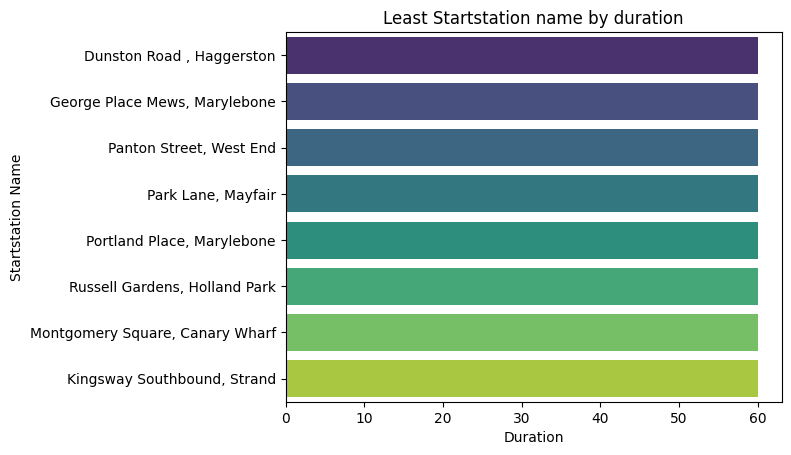

In [ ]:
least_duration_by_startstation = least_duration_by_startstation.toPandas()
least_duration_by_startstation = least_duration_by_startstation.head(8)
sns.barplot(data=least_duration_by_startstation, y="Startstation Name", x="duration", hue=least_duration_by_startstation["Startstation Name"], palette="viridis")
plt.xlabel("Duration")
plt.ylabel("Startstation Name")
plt.title("Least Startstation name by duration");

In [ ]:
df.show(5)

+-------+--------+----------------+--------------------+----------------+--------------------+-----+----+
|Bike Id|Duration|        End Date|     EndStation Name|      Start Date|   StartStation Name|Month|Year|
+-------+--------+----------------+--------------------+----------------+--------------------+-----+----+
|  10900|    1200|07/07/2014 09:16|Rochester Row, We...|07/07/2014 08:56|Rossmore Road, Ma...|   07|2014|
|   1635|    2460|08/07/2014 10:00|Guilford Street ,...|08/07/2014 09:19|Watney Street, Sh...|   07|2014|
|  10455|     420|08/07/2014 20:15|Granby Street, Sh...|08/07/2014 20:08|Old Montague Stre...|   07|2014|
|   6448|     300|25/06/2014 19:21|Sadlers Sports Ce...|25/06/2014 19:16|Museum of London,...|   06|2014|
|  11198|    1620|16/07/2014 08:17|Moorfields, Moorgate|16/07/2014 07:50|Clarence Walk, St...|   07|2014|
+-------+--------+----------------+--------------------+----------------+--------------------+-----+----+
only showing top 5 rows



In [ ]:
duration_by_month = df.groupBy("Month").agg(avg('Duration').alias('duration')).orderBy(asc('Month'))
duration_by_month.show()

+-----+------------------+
|Month|          duration|
+-----+------------------+
|   01|1247.0505239090028|
|   02|1293.8808194609342|
|   03|1440.4395003557975|
|   04|1530.1822872056348|
|   05|1577.8602847558398|
|   06|1568.6224834397206|
|   07|1569.9078689512444|
|   08|1651.7460585208946|
|   09| 1413.699774683901|
|   10| 1354.910192715314|
|   11|1274.7543766125766|
|   12|1410.5882208820863|
+-----+------------------+



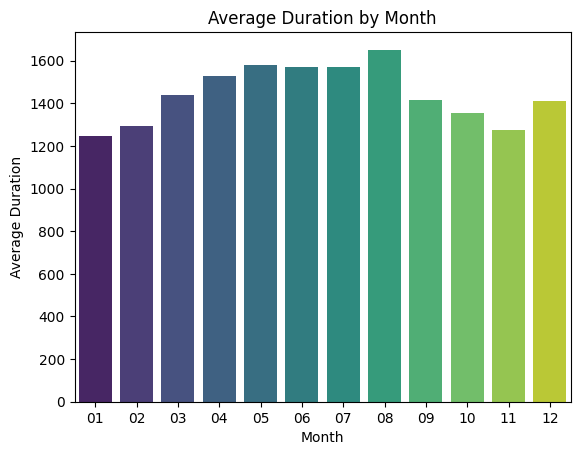

In [ ]:
duration_by_month = duration_by_month.toPandas()
sns.barplot(data=duration_by_month, x="Month", y="duration", hue=duration_by_month.Month, palette="viridis")
plt.xlabel("Month")
plt.ylabel("Average Duration")
plt.title("Average Duration by Month");

Reflection: The month of August have the highest rides in total while the month of January has the least

#DATA WRANGLING FOR HYPOTHESIS TEST

In [ ]:
# Applying a python lambda function to the "StartStation Name" column to create a new column for Baylis and others
df = df.withColumn("Baylis_and_others", udf(lambda name: "Baylis" if "Baylis" in name else "Others")(df["StartStation Name"]))
df.show()

+-------+--------+----------------+--------------------+----------------+--------------------+-----+----+-----------------+
|Bike Id|Duration|        End Date|     EndStation Name|      Start Date|   StartStation Name|Month|Year|Baylis_and_others|
+-------+--------+----------------+--------------------+----------------+--------------------+-----+----+-----------------+
|  10900|    1200|07/07/2014 09:16|Rochester Row, We...|07/07/2014 08:56|Rossmore Road, Ma...|   07|2014|           Others|
|   1635|    2460|08/07/2014 10:00|Guilford Street ,...|08/07/2014 09:19|Watney Street, Sh...|   07|2014|           Others|
|  10455|     420|08/07/2014 20:15|Granby Street, Sh...|08/07/2014 20:08|Old Montague Stre...|   07|2014|           Others|
|   6448|     300|25/06/2014 19:21|Sadlers Sports Ce...|25/06/2014 19:16|Museum of London,...|   06|2014|           Others|
|  11198|    1620|16/07/2014 08:17|Moorfields, Moorgate|16/07/2014 07:50|Clarence Walk, St...|   07|2014|           Others|
|  10471

In [ ]:
# Perform value counts on the "Bailey_and_others" column
value_counts = df.groupBy("Baylis_and_others").count()
value_counts.show()

+-----------------+-------+
|Baylis_and_others|  count|
+-----------------+-------+
|           Baylis|  26326|
|           Others|9837835|
+-----------------+-------+



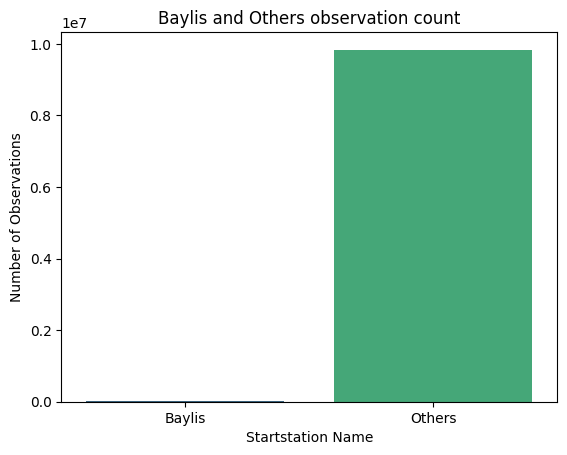

In [ ]:
value_counts_df = value_counts.toPandas()
sns.barplot(data= value_counts_df, x="Baylis_and_others", y="count", hue ="Baylis_and_others", palette="viridis")
plt.title('Baylis and Others observation count')
plt.xlabel('Startstation Name')
plt.ylabel('Number of Observations');

In [ ]:
average_duration_df = df.groupBy(["Month", "Baylis_and_others"]).agg(avg("Duration").alias("average_ride_by_month"))
average_duration_df.orderBy(average_duration_df.Month.asc()).show(24)

+-----+-----------------+---------------------+
|Month|Baylis_and_others|average_ride_by_month|
+-----+-----------------+---------------------+
|   01|           Baylis|    960.2870813397129|
|   01|           Others|   1247.9157566495696|
|   02|           Others|   1294.5294721724779|
|   02|           Baylis|   1064.6280991735537|
|   03|           Baylis|     894.668721109399|
|   03|           Others|   1441.8672406565413|
|   04|           Baylis|    881.6007714561234|
|   04|           Others|   1531.8810665818007|
|   05|           Baylis|    1050.938673341677|
|   05|           Others|   1579.3038874589104|
|   06|           Others|   1569.8077658723566|
|   06|           Baylis|    1110.615901455767|
|   07|           Others|   1570.6447931673715|
|   07|           Baylis|   1286.0921445144184|
|   08|           Others|   1653.3606386887209|
|   08|           Baylis|   1029.8165481093224|
|   09|           Baylis|   1247.9394812680116|
|   09|           Others|   1414.1419520

In [ ]:
hypothesis_testing_df = average_duration_df.groupBy("Month").pivot("Baylis_and_others").agg(first("average_ride_by_month"))
hypothesis_testing_df = hypothesis_testing_df.withColumnRenamed("Baylis", "Average_ride_by_month_Baylis").withColumnRenamed("Others", "Average_ride_by_month_Others")

In [ ]:
hypothesis_testing_df = hypothesis_testing_df.orderBy(hypothesis_testing_df.Month.asc())
hypothesis_testing_df.show()

+-----+----------------------------+----------------------------+
|Month|Average_ride_by_month_Baylis|Average_ride_by_month_Others|
+-----+----------------------------+----------------------------+
|   01|           960.2870813397129|          1247.9157566495696|
|   02|          1064.6280991735537|          1294.5294721724779|
|   03|            894.668721109399|          1441.8672406565413|
|   04|           881.6007714561234|          1531.8810665818007|
|   05|           1050.938673341677|          1579.3038874589104|
|   06|           1110.615901455767|          1569.8077658723566|
|   07|          1286.0921445144184|          1570.6447931673715|
|   08|          1029.8165481093224|          1653.3606386887209|
|   09|          1247.9394812680116|          1414.1419520740462|
|   10|           879.4212765957446|          1356.1646696133168|
|   11|          1048.9418777943367|          1275.4024138845407|
|   12|           851.7014122394082|          1412.0464056175222|
+-----+---

#VISUALIZATIONS

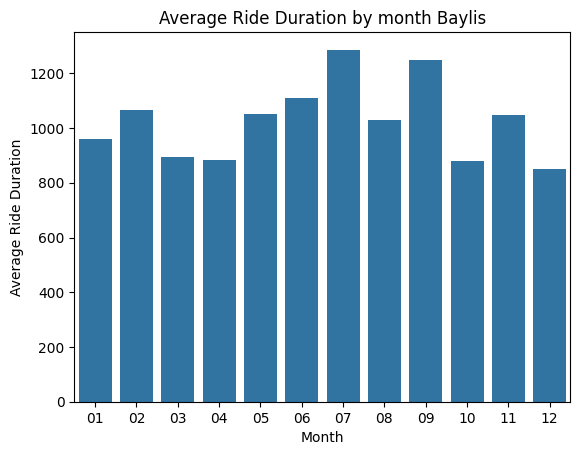

In [ ]:
tfl = hypothesis_testing_df.toPandas()
sns.barplot(data=tfl, x="Month", y="Average_ride_by_month_Baylis")
plt.title('Average Ride Duration by month Baylis')
plt.xlabel('Month')
plt.ylabel('Average Ride Duration');

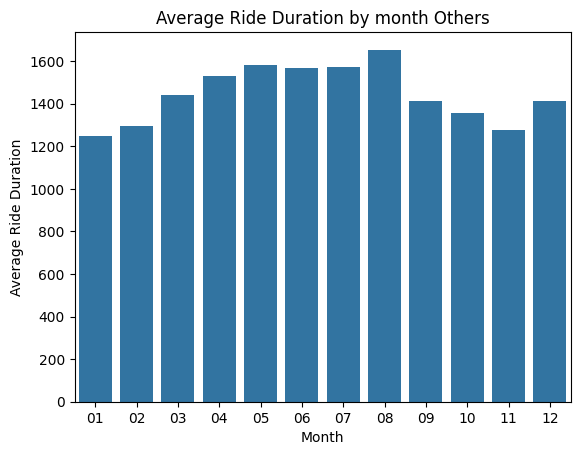

In [ ]:
sns.barplot(data=tfl, x="Month", y="Average_ride_by_month_Others")
plt.title('Average Ride Duration by month Others')
plt.xlabel('Month')
plt.ylabel('Average Ride Duration');

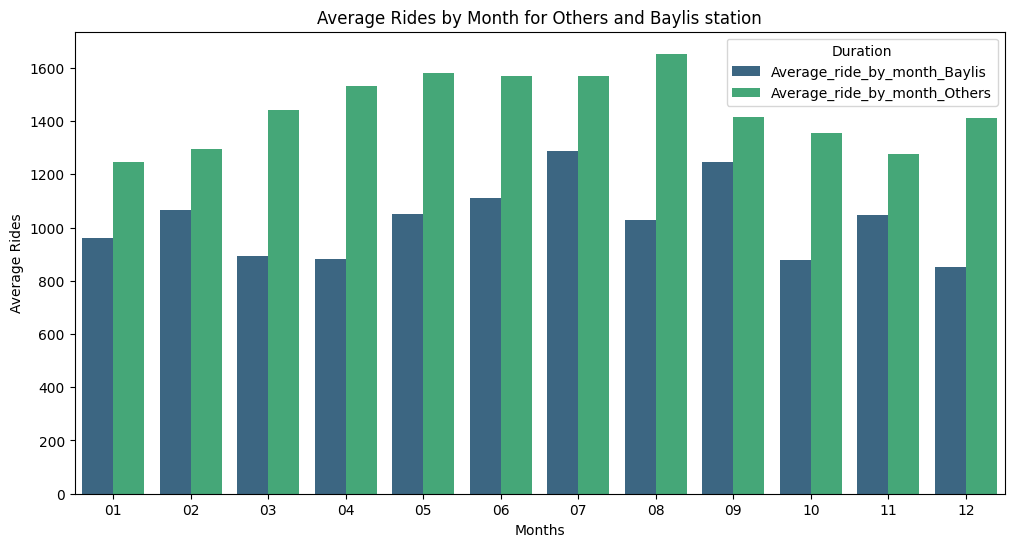

In [ ]:
plt.figure(figsize=(12, 6))
tfl_plot = tfl.melt(id_vars='Month', var_name='Duration', value_name='Duration of rides')
sns.barplot(x='Month', y='Duration of rides', hue='Duration', data=tfl_plot, palette='viridis')
plt.xlabel('Months')
plt.ylabel('Average Rides')
plt.title('Average Rides by Month for Others and Baylis station');

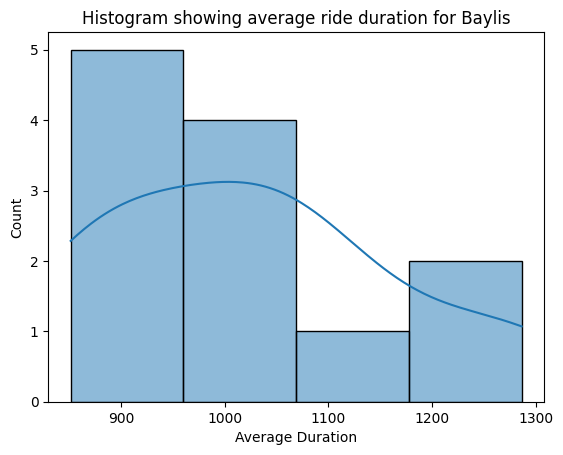

In [ ]:
sns.histplot(data=tfl, x="Average_ride_by_month_Baylis", bins=4, kde=True)
plt.xlabel('Average Duration')
plt.ylabel('Count')
plt.title('Histogram showing average ride duration for Baylis');

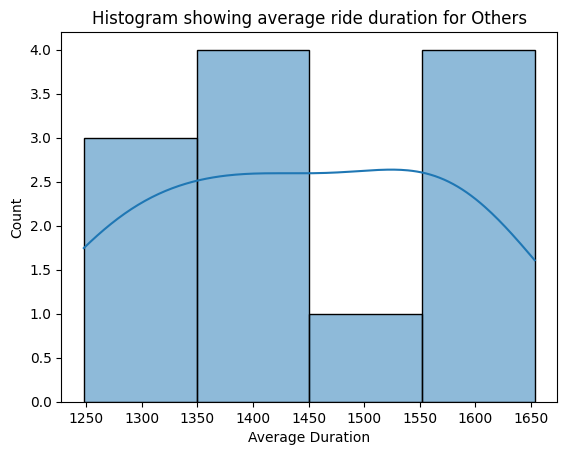

In [ ]:
sns.histplot(data=tfl, x="Average_ride_by_month_Others", bins=4, kde=True)
plt.xlabel('Average Duration')
plt.ylabel('Count')
plt.title('Histogram showing average ride duration for Others');

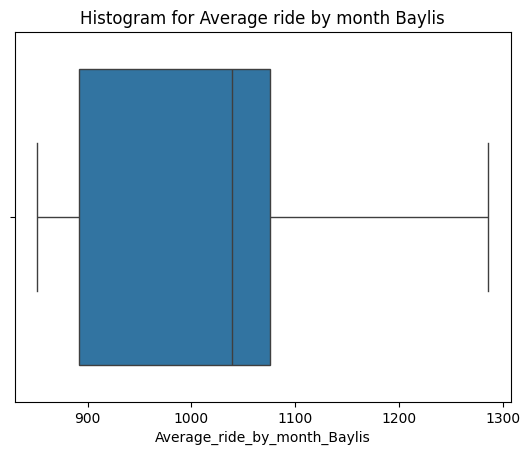

In [ ]:
sns.boxplot(data=tfl, x="Average_ride_by_month_Baylis")
plt.title("Histogram for Average ride by month Baylis");

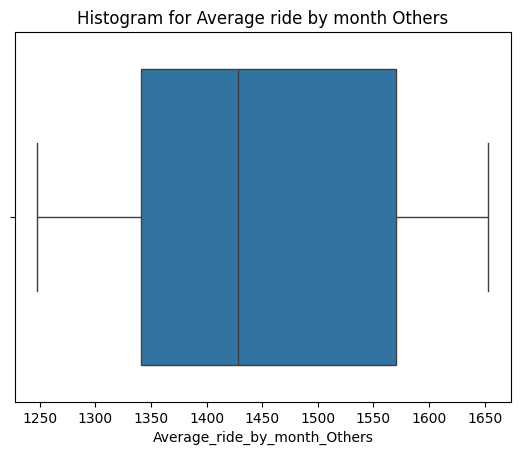

In [ ]:
sns.boxplot(data=tfl, x="Average_ride_by_month_Others")
plt.title("Histogram for Average ride by month Others");

In [ ]:
tfl.head()

,Month,Average_ride_by_month_Baylis,Average_ride_by_month_Others
0,01,960.287081,1247.915757
1,02,1064.628099,1294.529472
2,03,894.668721,1441.867241
3,04,881.600771,1531.881067
4,05,1050.938673,1579.303887


#HYPOTHESIS TESTING

Null Hypothesis H(0): Rides originating from Baylis Road, Waterloo station in 2014 were longer than those from other stations.


Alternate Hypothesis H(1): Rides originating from Baylis Road, Waterloo station in 2014 were shorter than those from other stations.

The hypothesis test will be done in 2 ways
1. Manually calculating the mean, variances and the number of samples of the two groups Baylis and Others and using the independent t test formular and the effect size to determine the validity of our research question
2. Using scipy to do the same analysis

##Major conditions to be met before conducting and independent sample t test

*   Homogeneity of Variances
*   Normality of data




##Levene's test for homogeneity of group Variance (Baylis and Others)

Since the Independent t test requires homogeneity of variance for the groups, Levene's test will be conducted to check this

Levene's test:
Null hypothesis: The variances of the groups are equal
Alternate hypothesis: The variances of the groups are not equal
Significance level alpha = 5% or 0.05

In [ ]:
from scipy.stats import levene

In [ ]:
observations_baylis = [row[0] for row in hypothesis_testing_df.select('Average_ride_by_month_Baylis').collect()]
observations_others = [row[0] for row in hypothesis_testing_df.select('Average_ride_by_month_Others').collect()]

In [ ]:
print(observations_baylis)
print(observations_others)

[960.2870813397129, 1064.6280991735537, 894.668721109399, 881.6007714561234, 1050.938673341677, 1110.615901455767, 1286.0921445144184, 1029.8165481093224, 1247.9394812680116, 879.4212765957446, 1048.9418777943367, 851.7014122394082]
[1247.9157566495696, 1294.5294721724779, 1441.8672406565413, 1531.8810665818007, 1579.3038874589104, 1569.8077658723566, 1570.6447931673715, 1653.3606386887209, 1414.1419520740462, 1356.1646696133168, 1275.4024138845407, 1412.0464056175222]


In [ ]:
levene_statistic, levene_p_value = levene(observations_baylis, observations_others)
print("Levene's test statistic:", levene_statistic)
print("levene_p-value:", levene_p_value)

Levene's test statistic: 0.008441687309400883
levene_p-value: 0.9276259513220582


In [ ]:
alpha = 0.05
if levene_p_value <= alpha:
    print("Reject the null hypothesis: Variances are not equal.")
else:
    print("Fail to reject the null hypothesis: Variances are equal.")

Fail to reject the null hypothesis: Variances are equal.


Since the p-value (0.9276) is greater than the significance level (0.05), we will fail to reject the null hypothesis.Therefore, there is not enough evidence to suggest that the variances of the two groups (Baylis and Others) are different.

##Shapiro Wilk test for normality of data points in Baylis and Others group

In [ ]:
from scipy.stats import shapiro

In [ ]:
#Since we already have a list of observations from the groups, It will be plugged in
shapiro_statistic_baylis, shapiro_p_value_baylis = shapiro(observations_baylis)
shapiro_statistic_others, shapiro_p_value_others = shapiro(observations_others)

In [ ]:
print("Shapiro-Wilk Test for Baylis:")
print("Test Statistic:", shapiro_statistic_baylis)
print("p-value:", shapiro_p_value_baylis)
print("Is the data normally distributed (p > 0.05)?:", shapiro_p_value_baylis > 0.05)
print("Shapiro-Wilk Test for Others:")
print("Test Statistic:", shapiro_statistic_others)
print("p-value:", shapiro_p_value_others)
print("Is the data normally distributed (p > 0.05)?:", shapiro_p_value_others > 0.05)

Shapiro-Wilk Test for Baylis:
Test Statistic: 0.9164214730262756
p-value: 0.2576427757740021
Is the data normally distributed (p > 0.05)?: True
Shapiro-Wilk Test for Others:
Test Statistic: 0.9376623630523682
p-value: 0.46839526295661926
Is the data normally distributed (p > 0.05)?: True


Since the p-values for Baylis and Others is greater than the significance level (0.05), we fail to reject the null hypothesis.Therefore, there is not enough evidence to conclude that the data significantly deviates from a normal distribution. Since Shapiro Wilk’s test is sensitive to sample sizes, histograms were plotted as well to verify the normality of the groups.

##Independent Sample T test using scipy

Since there is homogeneity of variance and normality in our groups (Baylis and Others) We can conduct an independent samples t- test on the data.

In [ ]:
from scipy.stats import ttest_ind

In [ ]:
t_statistic, p_value = ttest_ind(observations_baylis, observations_others, equal_var=True, alternative="less")
print("Independent Samples t-test:")
print("t-statistic:", t_statistic)
print("p-value:", p_value)

Independent Samples t-test:
t-statistic: -7.4327479175820175
p-value: 9.786575276234225e-08


In [ ]:
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the means of the two groups (Baylis and Others).")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the means of the two groups (Baylis and Others).")

Reject the null hypothesis: There is a significant difference between the means of the two groups (Baylis and Others).


##Independent T test (Manual with scipy)

Steps:
1. Get the sample size for Baylis and Others
2. Calculate the means for Baylis and Others
3. Calculate the standard deviation of Baylis and Others

In [ ]:
mean_duration_baylis = hypothesis_testing_df.select(mean(hypothesis_testing_df['Average_ride_by_month_Baylis'])).collect()[0][0]
mean_duration_baylis

1025.5543323664563

In [ ]:
mean_duration_others = hypothesis_testing_df.select(mean(hypothesis_testing_df['Average_ride_by_month_Others'])).collect()[0][0]
mean_duration_others

1445.5888385364312

In [ ]:
std_duration_baylis = hypothesis_testing_df.select(stddev(hypothesis_testing_df['Average_ride_by_month_Baylis'])).collect()[0][0]
std_duration_baylis

141.74241590910438

In [ ]:
std_duration_others = hypothesis_testing_df.select(stddev(hypothesis_testing_df['Average_ride_by_month_Others'])).collect()[0][0]
std_duration_others

135.0239204135971

In [ ]:
sample_number_baylis = hypothesis_testing_df.select('Average_ride_by_month_Baylis').count()
sample_number_others = hypothesis_testing_df.select('Average_ride_by_month_Others').count()

In [ ]:
print(f"Sample number of Baylis: {sample_number_baylis}")
print(f"Sample number of Others: {sample_number_others}")

Sample number of Baylis: 12
Sample number of Others: 12


In [ ]:
t = (mean_duration_baylis - mean_duration_others)/np.sqrt(std_duration_baylis**2/sample_number_baylis + std_duration_others**2/sample_number_others)
t

-7.432747917582016

In [ ]:
degrees_of_freedom = sample_number_baylis + sample_number_others - 2
degrees_of_freedom

22

In [ ]:
manual_alpha = 0.05
manual_alpha

0.05

In [ ]:
#From the t-distribution table using alpha of 0.05 and degrees_of_freedom of 22
critical_value = 1.717
critical_value

1.717

In [ ]:
from scipy import stats
manual_p_value = stats.t.cdf(t, degrees_of_freedom)
print("manual_p-value:", manual_p_value)

manual_p-value: 9.786575276234278e-08


In [ ]:
print("Independent Samples t-test Manual:")
print("t-statistic:", t)
print("manual_p-value:", manual_p_value)

Independent Samples t-test Manual:
t-statistic: -7.432747917582016
manual_p-value: 9.786575276234278e-08


In [ ]:
manual_alpha = 0.05
if manual_p_value < manual_alpha:
    print("Reject the null hypothesis: There is a significant difference between the means of the two groups (Baylis and Others).")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the means of the two groups (Baylis and Others).")

Reject the null hypothesis: There is a significant difference between the means of the two groups (Baylis and Others).


This t statistic and the p_value follows exactly as the one calculated with the scipy library

#CONCLUSION OF HYPOTHESIS TEST

Since there is a significant difference between the average duration of rides originating from Baylis Road, Waterloo station in 2014 compared to other stations, we reject the null hypothesis. This means that rides originating from Baylis Road, Waterloo station in 2014 were in actual sense significantly shorter than those from other stations at a significance level of 0.05.